In [112]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
from scipy.signal.windows import windows

from training.spectrogram import move_front_half_to_end


In [61]:
data = np.load(f"data/numpy/SNR30_ZBW.npy")[:500000]
SAMPLE_RATE = 88000000

/var/folders/81/3wz7wxg90f3df6qvy1xbf71m0000gn/T/ipykernel_51120/1537016865.py:13: DeprecationWarning: Please import `kaiser` from the `scipy.signal.windows` namespace; the `scipy.signal.windows.windows` namespace is deprecated and will be removed in SciPy 2.0.0.
  hamm_win = windows.kaiser(256, 5)


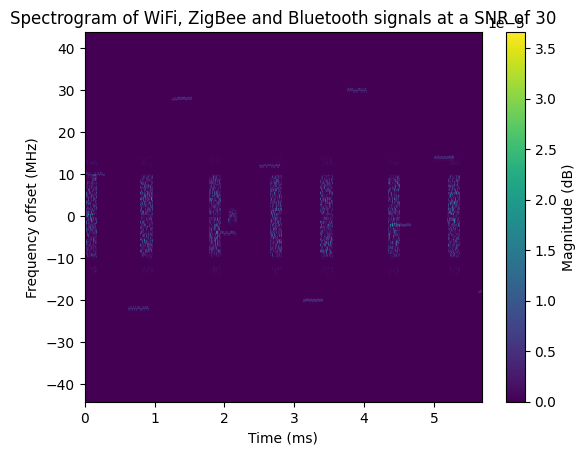

In [125]:
# f, t, Zxx = signal.stft(x=data, fs=SAMPLE_RATE, return_onesided=False)
f, t, Sxx = signal.stft(x=data,
                        fs=SAMPLE_RATE,
                        noverlap=220,
                        nfft=256,
                        return_onesided=False)
Sxx = (np.abs(Sxx) ** 2)
Sxx = move_front_half_to_end(Sxx)
f = move_front_half_to_end(f)
f = f / 1000000  # rescale to MHz
t = t * 1000  # Rescale to milliseconds

hamm_win = windows.kaiser(256, 5)
scale = np.sqrt(1.0 / hamm_win.sum() ** 2)
Sxx = Sxx / scale

plt.pcolormesh(t, f, Sxx, shading='auto')
plt.title("Spectrogram of WiFi, ZigBee and Bluetooth signals at a SNR of 30")
plt.ylabel("Frequency offset (MHz)")
plt.xlabel("Time (ms)")
# plt.ticklabel_format(axis='y', style='scientific', scilimits=(1, 8))
# plt.clim(vmin=-80, vmax=-20)
plt.colorbar(label='Magnitude (dB)')
plt.show()